# Individual Planning Report - Luke Angelo Santiago

## Question

We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts. 
- We will be using the players dataset.
- We are trying to predict played hours.
- Our predictor variables would be experience, gender, and age.
- In order to perform a classification predictive method using the experience and gender variables, they must first changed to of factor type so that R and `tidyverse` can treat it as a category.

## Methods and Plan

- By using a K-NN regression, we can predict a player's played hours. 'K-NN' is an appropriate engine in order to consider for any possible non-linear relationship with the predictor variables. 'Classification' is the most appropriate mode as played hours is a numerical value rather than a class value
- Potential limitations of a K-NN classification is that it does not performing well under imbalanced classes. This can be resolved by scaling and centering the predictors beforehand.
- Since we have a small number of observations, we will split the data only slightly towards the training set (\~70% of observations in training data, \~30% of observations in testing data).
- To compare and select our models:
  - Since no one value in experience, gender, and age is worth noting more than another, then the best way to compare models is with accuracy.
  - Since there are a relatively small amount of observations (196 in total), we will use a 10-fold cross-validation on our training set as computational power would be relatively low.

## Explaratory Data Analysis and Visualization

In [19]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

### Tibbles

In [20]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url) |>

    # experience and gender changed to factor type in order to be treated as category
    mutate(experience = as.factor(experience),
           gender = as.factor(gender)) |>

    # individualId and organizationName removed as they have no information
    select(-individualId, -organizationName)

players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


In [21]:
# number of players in each experience level
players |>
    group_by(experience) |>
    summarize(count = n()) |>
    arrange(count)

experience,count
<fct>,<int>
Pro,14
Beginner,35
Regular,36
Veteran,48
Amateur,63


In [22]:
# number of players from a certain gender
players |>
    group_by(gender) |>
    summarize(count = n()) |>
    arrange(count)

gender,count
<fct>,<int>
Other,1
Agender,2
Two-Spirited,6
⋮,⋮
Non-binary,15
Female,37
Male,124


### Plots

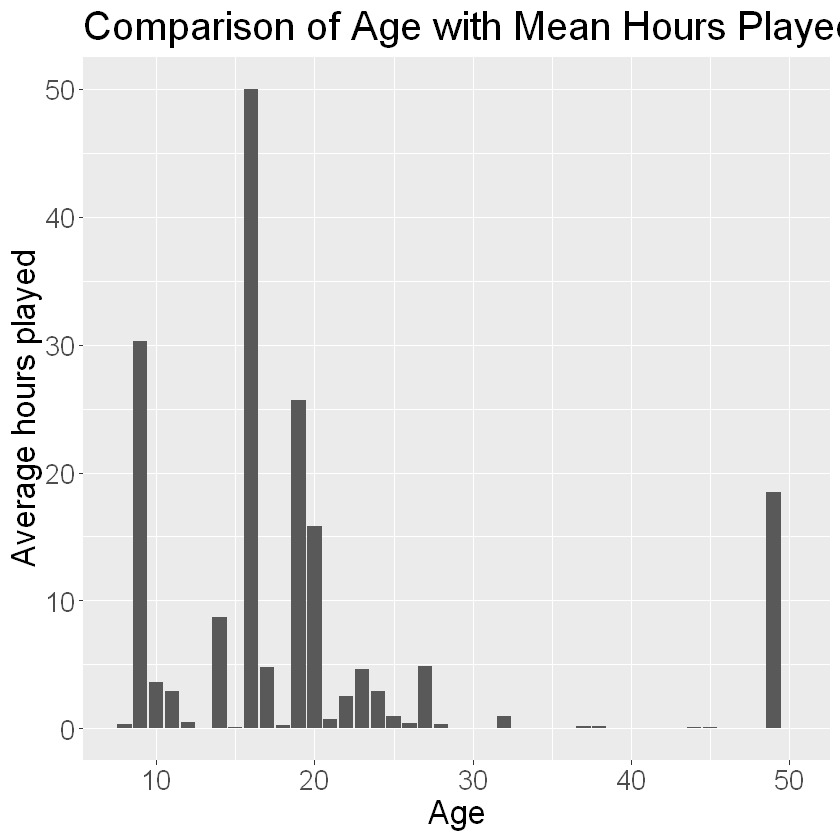

In [23]:
# graph comparing age with their mean amount of playing hours
age_vs_mean_hours <- players |>
    filter(age < 51) |>
    group_by(age) |>
    summarize(avg_played_hours = mean(played_hours)) |>
    ggplot(aes(x = age, y = avg_played_hours)) +
    geom_bar(stat = "identity") +
    labs(x = "Age",
         y = "Average hours played",
         title = "Comparison of Age with Mean Hours Played") +
    theme(text = element_text(size = 20))

age_vs_mean_hours

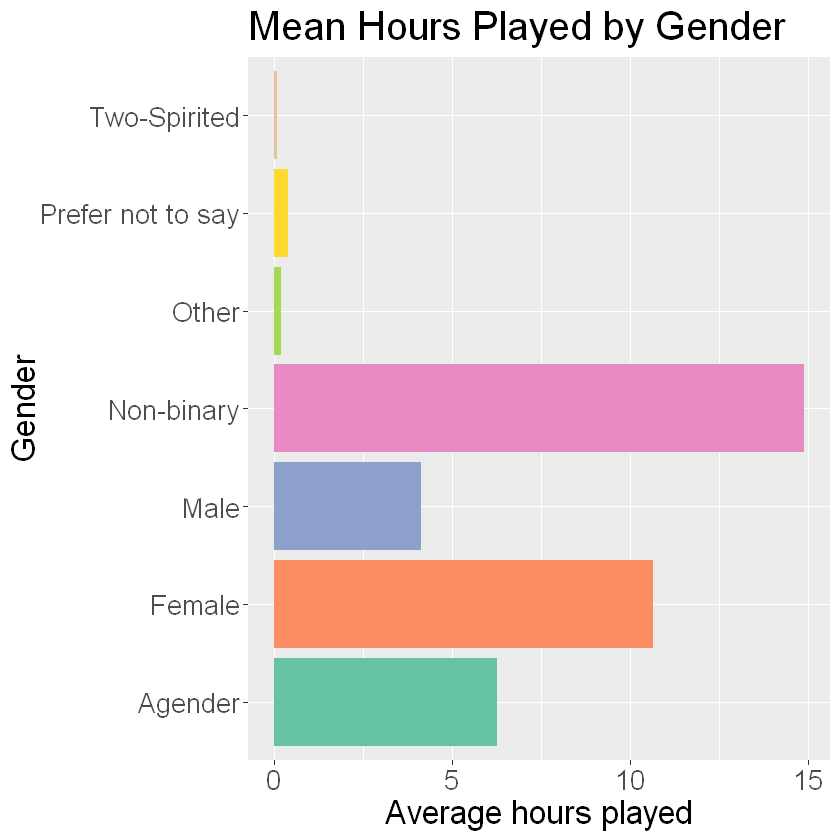

In [24]:
# graph comparing gender with their mean amount of playing hours
gender_vs_hours <- players |>
    group_by(gender) |>
    summarize(avg_played_hours = mean(played_hours)) |>
    ggplot(aes(x = avg_played_hours, y = gender, fill = gender)) +
    geom_bar(stat = "identity") +
    labs(x = "Average hours played",
         y = "Gender",
         title = "Mean Hours Played by Gender") +
    guides(fill="none") +
    theme(text = element_text(size = 20)) +
    scale_fill_brewer(palette = 'Set2')

gender_vs_hours

Warning message in geom_histogram(stat = "identity", position = "dodge"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


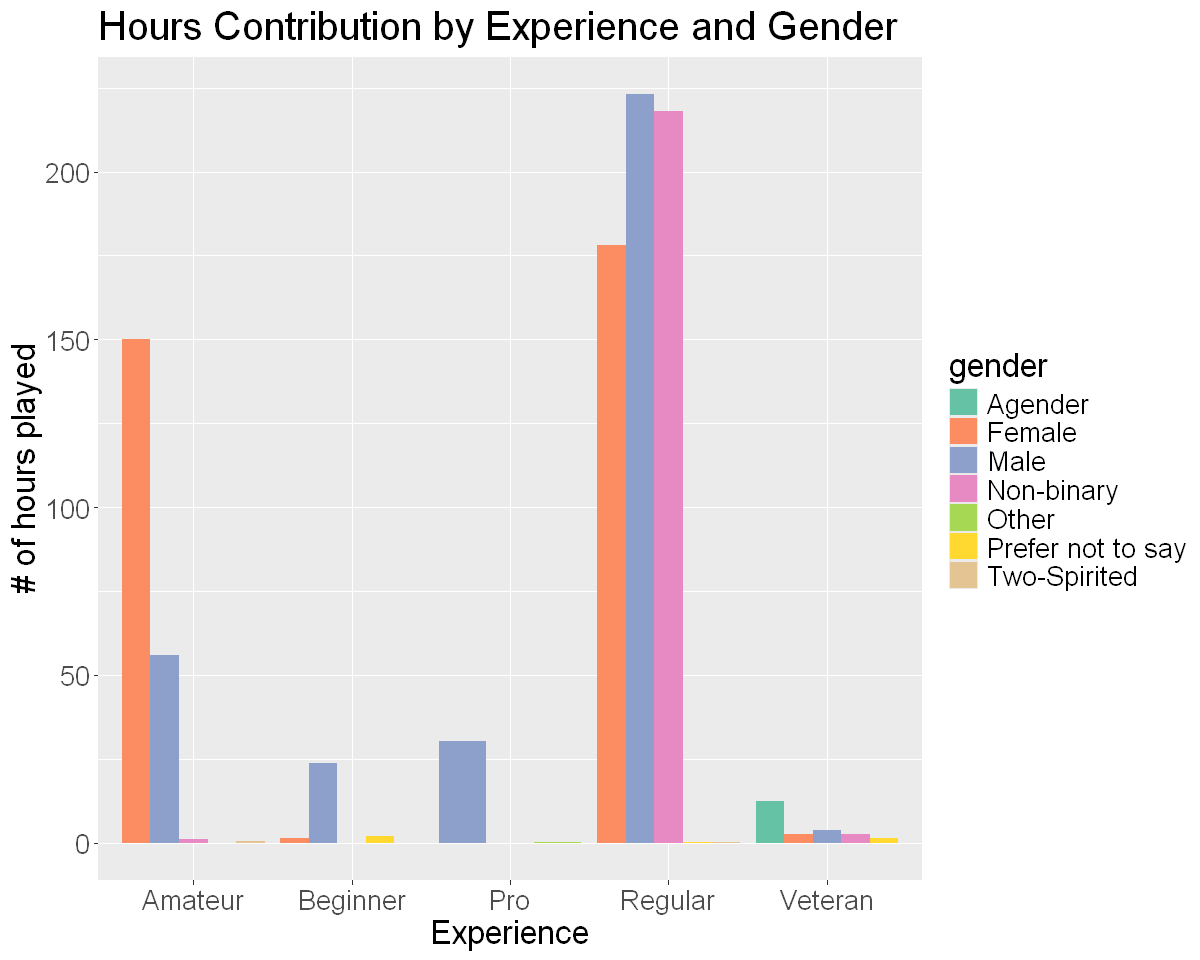

In [25]:
options(repr.plot.width = 10, repr.plot.height = 8)

# hours contributed by experience level and gender
experience_vs_hours <- players |>
    ggplot(aes(x = experience, y = played_hours, fill = gender)) +
    geom_histogram(stat = "identity", position = "dodge") +
    labs(x = "Experience",
         y = "# of hours played",
         title = "Hours Contribution by Experience and Gender") +
    theme(text = element_text(size = 20)) +
    scale_fill_brewer(palette = 'Set2')

experience_vs_hours

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


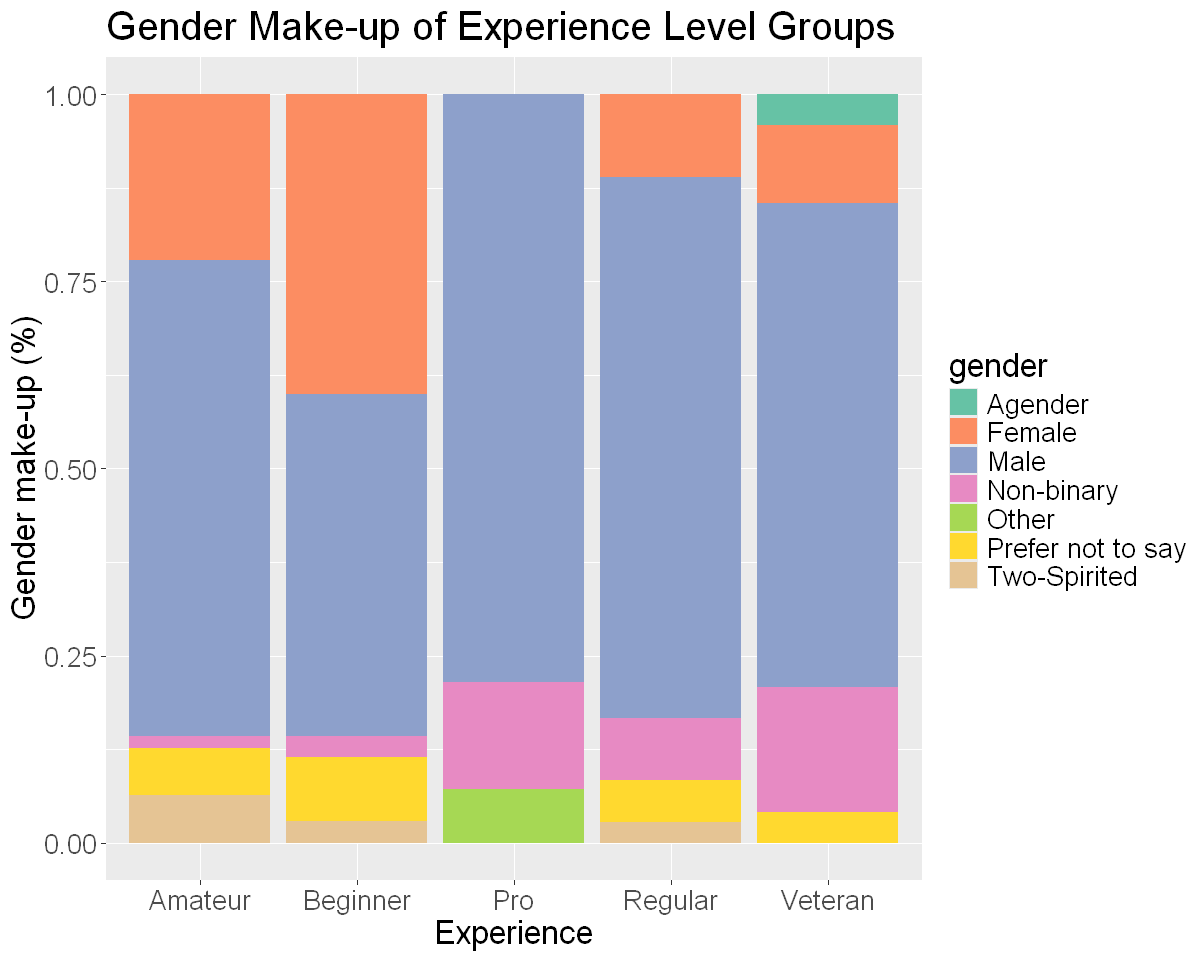

In [26]:
# graph comparing the gender make-up in each experience level group
gender_makeup <- players |>
    group_by(gender, experience) |>
    summarize(count = n()) |>
    ggplot(aes(x = experience, y = count, fill = gender)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Experience",
         y = "Gender make-up (%)",
         title = "Gender Make-up of Experience Level Groups") +
    theme(text = element_text(size = 20)) +
    scale_fill_brewer(palette = 'Set2')

gender_makeup

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


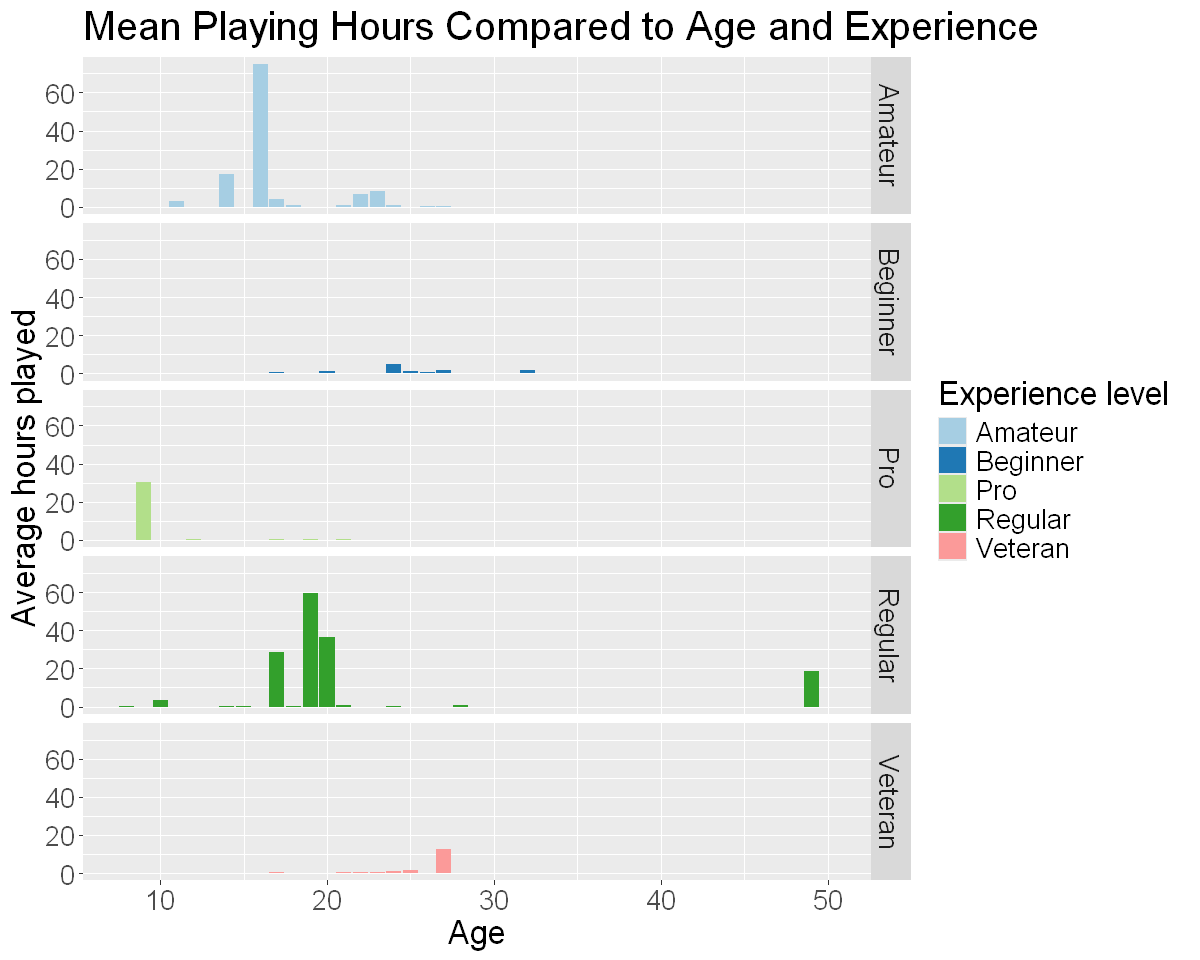

In [27]:
# Each experience level group's mean hours based on age
players_bar <- players |>
    filter(age < 51) |>
    group_by(age, experience) |>
    summarize(avg_played_hours = mean(played_hours)) |>
    ggplot(aes(x = age, y = avg_played_hours, fill = experience)) +
    geom_bar(stat = "identity") +
    facet_grid(rows = vars(experience)) +
    labs(x = "Age",
         y = "Average hours played",
         fill = "Experience level",
         title = "Mean Playing Hours Compared to Age and Experience") +
    theme(text = element_text(size = 20)) +
    scale_fill_brewer(palette = 'Paired')

players_bar

Insights seen from the plots:
- Male players vastly dominate the participant demographic. Consequently, they deliver the most hours to the study despite having the lowest hours contributed per capita.
- Regular and amateur players contributed the most hours to the study.
- Non-binary and female players tend to play more.
- The dataset is mostly comprised of pre-adolescents and young adults.

## Data Description

`players` is a dataset that has 196 observations. This data was from a .csv file provided by the researchers at PLAICRAFT, where the information was collected by survey and game tracking. The 6 (useable) variables of the data set are the following:
- `experience` : a variable of type factor describing the amount of experience each player has. The original type of the variable was of character, but since it had 5 discrete values, we changed it to type factor so that R and `tidyverse` could treat it as a category.
  - There are 5 categories:
    - `"Amateur"` (n = 63)
    - `"Beginner"` (n = 35)
    - `"Pro"` (n = 14)
    - `"Regular"` (n = 36)
    - `"Veteran"` (n = 48)
- `subscribe` : a variable of type logical describing whether they are part of the mailing list.
- `played_hours` : a variable of type double describing the player's played hours.
- `name` : a variable of type character describing the player's name.
- `gender` : a variable of type factor describing the player's gender. The original type was of type character, but since it has 7 discrete values, it was changed to type factor so that R and `tidyverse` can treat it as a category.
  - There are 7 categories:
    - `"Agender"` (n = 2)
    - `"Female"` (n = 37)
    - `"Male"` (n = 124)
    - `"Non-binary"` (n = 15)
    - `"Other"` (n = 1)
    - `"Prefer not to say"` (n = 11)
    - `"Two-Spirited"` (n = 6)
- `age` : a variable of type double describing the player's age.
- (REMOVED) `individualId`: a variable assumed to describe the player's given ID. Removed due to lack of values.
- (REMOVED) `organizationName` : a variable describing the player's organization. Removed due to lack of values.